In [12]:
import argparse
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import torch
import uuid

from botorch.models import SingleTaskGP, ModelListGP
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean

from botorch.optim import optimize_acqf
from common import seed_generator, configs
from common.utils import get_int, get_qe
from common import utils
from fireworks import LaunchPad
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from jobflow import JobStore
from jobflow.managers.fireworks import flow_to_workflow
from maggma.stores.mongolike import MongoStore
from NanoParticleTools.flows.flows import get_npmc_flow
from NanoParticleTools.inputs.nanoparticle import SphericalConstraint
from random import randrange


In [10]:
def get_data_botorch(data_file, from_cloud = True):
    if from_cloud:
        df = gcloud_utils.get_df_gspread(GSPREAD_CRED, GSPREAD_NAME)
        #df = df.drop(labels=range(1, 600), axis=0)
        my_data = df.to_numpy()
        print(f"reading data log from google sheet: {GSPREAD_NAME}!")
    else:
        my_data = np.loadtxt(data_file, delimiter=',', skiprows=1)
        print(f"reading data log from local: {data_file}!")

    # features
    train_x = torch.from_numpy(my_data[:, :5])
    # labels
    train_y = torch.from_numpy(my_data[:, 5]).unsqueeze(-1)
    # best observation
    best_y = train_y.max().item()
    
    return train_x, train_y, best_y


def encode_inputs(x_arr, x_max = 34):
    '''encode simulation input to botorch'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0] = arr[0] + arr[1]
        if arr[0] + arr[1] == 0:
            x_arr[i, 1] = 0.5
        else:
            x_arr[i, 1] = arr[0] / (arr[0] + arr[1])
        x_arr[i, 2] = arr[2] + arr[3]
        if arr[2] + arr[3] == 0:
            x_arr[i, 3] = 0.5
        else:
            x_arr[i, 3] = arr[2] / (arr[2] + arr[3])
        x_arr[i, 4] = arr[4] / x_max


def decode_candidates(x_arr, x_max = 34):
    '''decode botorch recommendation candidates for simulation'''
    for i, arr in enumerate(x_arr):
        x_arr[i, 0], x_arr[i, 1] = arr[0] * arr[1], arr[0] * (1 - arr[1])
        x_arr[i, 2], x_arr[i, 3] = arr[2] * arr[3], arr[2] * (1 - arr[3])
        x_arr[i, 4] = arr[4] * x_max

def recommend(train_x, train_y, best_y, bounds, n_trails = 5):
    if isinstance(bounds, list):
        bounds = torch.tensor(bounds)
    elif torch.is_tensor(bounds):
        pass
    else:
        raise TypeError(f"expect bounds in a list or tensor. was given {type(bounds)}")
    
    single_model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    # Expected Improvement acquisition function
    EI = qExpectedImprovement(model = single_model, best_f = best_y)
    # Upper Confidence Bound acquisition function
    UCB = UpperConfidenceBound(single_model, beta=100)
    
    # hyperparameters are super sensitive here
    candidates, _ = optimize_acqf(acq_function = UCB,
                                 bounds = bounds, 
                                 q = n_trails, 
                                 num_restarts = 20, 
                                 raw_samples = 512, 
                                # options = {'batch_limit': 5, "maxiter": 200}
                                 )
    
    return candidates
# New functions for pool-based AL. Different from real-test AL.

# recommend the next NP from the pool
def recommend_next(train_X,train_Y,test_X, beta):
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    UCB = UpperConfidenceBound(single_model, beta)

    ucb = UCB(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ucb.detach().numpy())
    max_ucb = max(ucb.detach().numpy())
    if max_ucb != ucb.detach().numpy()[max_idx]:
        print('wrong index')
    return max_idx, test_X[max_idx], test_y[max_idx]
# recommend the next NP from the pool

def recommend_next_EI(train_X,train_Y,test_X):
    best_Y = max(train_Y)
    print(best_Y)
    single_model = SingleTaskGP(train_X,train_Y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    #qEI
    EI = qExpectedImprovement(model = single_model, best_f = best_Y)
    #PI
    #EI = ProbabilityOfImprovement(model = single_model, best_f = best_Y)
    ei = EI(torch.unsqueeze(test_X,1))
    max_idx = np.argmax(ei.detach().numpy())
    max_ei = max(ei.detach().numpy())
    if max_ei != ei.detach().numpy()[max_idx]:
        print('wrong index')
        print(f'max_ei ({max_ei}) != ei[max_idx]({ei.detach().numpy()[max_idx]})')
    return max_idx, test_X[max_idx], test_y[max_idx]

def recommend_next_RS(train_X,train_Y,test_X):
    max_idx = randrange(len(test_X))
    return max_idx, test_X[max_idx], test_y[max_idx]
    
# log results to csv
def log_result(test_X,test_Y,max_idx,data_dest):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    df_features = pd.DataFrame(features.reshape(-1, len(features)))
    df_obs = pd.DataFrame(obs)
    df_log = pd.concat([df_features,df_obs],axis=1)
    df_log.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']
    log = pd.read_csv(data_dest)
    log = log.append(df_log, ignore_index=True)
    log.to_csv(data_dest, index=False)

# append results to a list
# test_X: features of a sample
# test_Y: obs of a sample
# max_idx: the index of the just evaluated sample in the pool
# log: the list to append results (test_X, test_Y, max_idx)
def append_result(test_X,test_Y,max_idx,log):
    decode_candidates(test_X)
    features = test_X[max_idx].numpy()
    obs = test_Y[max_idx].numpy()
    result = np.concatenate((features, obs), axis=None)
    log.append(result)
    
# update pool: removing the new recommended NP from the pool
def update_pool(train_X,train_Y,test_X,test_Y,pool_X, pool_Y, max_idx):
    train_X, train_Y = torch.cat([train_X,torch.unsqueeze(pool_X[max_idx],0)]),torch.cat([train_Y,torch.unsqueeze(pool_Y[max_idx],0)])
    #print(pool_x[max_idx])
    if max_idx ==0:
        pool_X, pool_Y = pool_X[1:], pool_y[1:]
    elif max_idx ==(len(pool_X)-1):
        pool_X, pool_Y = pool_X[:-1], pool_y[:-1]
    else:
        pool_X, pool_Y = torch.cat([pool_X[:max_idx], pool_X[max_idx+1:]]), torch.cat([pool_Y[0:max_idx], pool_Y[max_idx+1:]]),
    test_X, test_Y = torch.clone(pool_X), torch.clone(pool_Y)
    return train_X,train_Y,test_X,test_Y,pool_X, pool_Y

# plot the result of a speified pool-based study:
#      calculate the best obs at at each step and plot the trajectory;
#      return the final best obs value and steps to achieve the best
def add_one_ensemble(log_seed,i):
    df = pd.DataFrame((log_seed[i]))
    df.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']

    evalued = len(df)
    max_uv = []
    y = df.UV
    for i in range(evalued):
        max_uv.append(df.iloc[0:i+1].UV.max())
    x = range(len(max_uv))
    max_x = len(max_uv)
    max_y = max(max_uv)    
    ax1.scatter(x, y, c='black', alpha = 0.3)
    ax2.plot(x, max_uv, c='r', alpha = 1)
    return max_x, max_y

In [97]:
# EI
s=0
print(f'initilizing seed {s}...')
random.seed(s)
# read pool from saved data
pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
encode_inputs(pool_x)
indices = list(np.arange(len(pool_x)))
index_pool = indices.copy()

# read x random initial samples from the pool
index_ = random.sample(index_pool, n_initial)
init_x, init_y = pool_x[index_], pool_y[index_]
train_x, train_y = torch.clone(init_x), torch.clone(init_y)
# remove the initial samples from the test pool
test_indices = list(set(indices)-set(index_))
pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

# check the max obs in the pool. 
# If max_obs smaller than the max in the original pool, the max sample is in the init samples. 
print(max(pool_y))

best_y = max(train_y)
print(best_y)
single_model = SingleTaskGP(train_x,train_y)
mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
fit_gpytorch_model(mll)
# EI = ExpectedImprovement(model = single_model, best_f = best_y)
EI = PosteriorMean(model = single_model)
ei = EI(torch.unsqueeze(test_x,1))
max_idx = np.argmax(ei.detach().numpy())
max_ei = max(ei.detach().numpy())
if max_ei != ei.detach().numpy()[max_idx]:
    print('wrong index')
    print(f'max_ei ({max_ei}) != ei[max_idx]({ei.detach().numpy()[max_idx]})')

# for i in range(100):
#     max_idx, max_feature, max_obs = recommend_next_EI(train_x,train_y,test_x)
#     print(i, max_idx, len(train_x),len(test_x))
#     append_result(test_x,test_y,max_idx,log_seed[count])
#     train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)


initilizing seed 0...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
tensor([9049.9994], dtype=torch.float64)
tensor([587.4996], dtype=torch.float64)


In [13]:
import random
from botorch.acquisition import UpperConfidenceBound

# Use this code if you want to specify the initial dataset saved under a directory
# init_x, init_y, _ = get_data_botorch("../saved_data/UV_log_shuffled_10initial_test1_beta=100.csv", from_cloud=False)
# train_x, train_y = init_x[:10], init_y[:10]

# Use this code to generate random initial datasets by selecting different seed values
# seed=[0,1,5,6,7,8,9,13,15,16] # for 10-sample inits
# seed=[0,5,6,8,9,13,15,16,18,19] # for 10-sample inits (PM)
seed=[0,5,6,8,13,15,16,19,23,24] # for 10-sample inits (PI)
#seed=[0,1,2,3,4,5,6,7,8,9] # for 20-inits
#seed=[0,1,11,12,13,5,6,7,8,9] # for 40-inits
#seed=[100,1,101,3,101,5,6,7,102,9]  #for 80-inits

beta = 0.001
n_initial = 10

log_seed=[] # the list to save results of each iteration
# generate an empty list of list. Length  = seed counts = n trials
for s in seed:
    log_seed.append([])

count = 0 # to track how many trials have been done
for s in seed:
    print(f'initilizing seed {s}...')
    random.seed(s)
    # read pool from saved data
    pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
    encode_inputs(pool_x)
    indices = list(np.arange(len(pool_x)))
    index_pool = indices.copy()

    # read x random initial samples from the pool
    index_ = random.sample(index_pool, n_initial)
    init_x, init_y = pool_x[index_], pool_y[index_]
    train_x, train_y = torch.clone(init_x), torch.clone(init_y)
    # remove the initial samples from the test pool
    test_indices = list(set(indices)-set(index_))
    pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
    test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

    # check the max obs in the pool. 
    # If max_obs smaller than the max in the original pool, the max sample is in the init samples. 
    # print(max(pool_y))
    
    #for i in range(len(pool_x)):
    for i in range(100):
#         max_idx, max_feature, max_obs = recommend_next(train_x,train_y,test_x, beta = beta)
        max_idx, max_feature, max_obs = recommend_next_RS(train_x,train_y,test_x)
        print(i, max_idx, len(train_x),len(test_x))
        append_result(test_x,test_y,max_idx,log_seed[count])

#         if (test_y[max_idx] >= max(test_y)):
#             print("reached best")
#             print(test_y[max_idx])
#             print(i)
#             break
        train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)
    count += 1

initilizing seed 0...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
0 597 10 666
1 223 11 665
2 516 12 664
3 142 13 663
4 288 14 662
5 143 15 661
6 97 16 660
7 633 17 659
8 256 18 658
9 545 19 657
10 616 20 656
11 150 21 655
12 317 22 654
13 101 23 653
14 75 24 652
15 338 25 651
16 483 26 650
17 573 27 649
18 103 28 648
19 362 29 647
20 444 30 646
21 323 31 645
22 625 32 644
23 209 33 643
24 565 34 642
25 488 35 641
26 453 36 640
27 533 37 639
28 266 38 638
29 63 39 637
30 561 40 636
31 14 41 635
32 95 42 634
33 408 43 633
34 1 44 632
35 626 45 631
36 505 46 630
37 341 47 629
38 249 48 628
39 333 49 627
40 64 50 626
41 195 51 625
42 581 52 624
43 227 53 623
44 244 54 622
45 145 55 621
46 556 56 620
47 458 57 619
48 93 58 618
49 82 59 617
50 327 60 616
51 520 61 615
52 501 62 614
53 111 63 613
54 308 64 612
55 564 65 611
56 298 66 610
57 127 67 609
58 560 68 608
59 340 69 607
60 553 70 606
61 208 71 605
62 560 72 604
63 601 73 603
64 294 74 602
65 455 75 601

52 514 62 614
53 237 63 613
54 183 64 612
55 556 65 611
56 512 66 610
57 362 67 609
58 80 68 608
59 240 69 607
60 317 70 606
61 318 71 605
62 168 72 604
63 325 73 603
64 396 74 602
65 487 75 601
66 344 76 600
67 452 77 599
68 75 78 598
69 278 79 597
70 485 80 596
71 145 81 595
72 118 82 594
73 504 83 593
74 399 84 592
75 385 85 591
76 15 86 590
77 266 87 589
78 94 88 588
79 294 89 587
80 65 90 586
81 42 91 585
82 461 92 584
83 60 93 583
84 261 94 582
85 162 95 581
86 511 96 580
87 578 97 579
88 492 98 578
89 510 99 577
90 44 100 576
91 512 101 575
92 63 102 574
93 485 103 573
94 83 104 572
95 473 105 571
96 237 106 570
97 459 107 569
98 261 108 568
99 86 109 567
initilizing seed 16...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
0 265 10 666
1 243 11 665
2 650 12 664
3 227 13 663
4 10 14 662
5 303 15 661
6 309 16 660
7 343 17 659
8 145 18 658
9 616 19 657
10 317 20 656
11 22 21 655
12 225 22 654
13 617 23 653
14 259 24 652
15 20 25 651
16 157 26 650
17 620

In [123]:
# use this one for trouble shooting
# sometimes the selected random seed results in max_obs in the initial dataset. Need a new seed.
# change the seed list and count value
# check beta values

seed=[23,24]
count = 8
#beta = 100000
log_seed[count]=[]
for s in seed:
    print(f'initilizing seed {s}...')
    random.seed(s)
    # read pool from saved data
    pool_x, pool_y, _ = get_data_botorch("../saved_data/simulation_log_from_gsheet.csv", from_cloud=False)
    encode_inputs(pool_x)
    indices = list(np.arange(len(pool_x)))
    index_pool = indices.copy()

    # read 10 random samples from the pool
    index_ = random.sample(index_pool, n_initial)
    init_x, init_y = pool_x[index_], pool_y[index_]
    train_x, train_y = torch.clone(init_x), torch.clone(init_y)
    test_indices = list(set(indices)-set(index_))
    pool_x, pool_y = pool_x[test_indices], pool_y[test_indices]
    test_x, test_y = torch.clone(pool_x), torch.clone(pool_y)

    # check the max obs in the pool
    print(max(pool_y))
    
    for i in range(100):
    #for i in range(3):
        max_idx, max_feature, max_obs = recommend_next_EI(train_x,train_y,test_x)
        print(i, max_idx, len(train_x),len(test_x))
        print(max_feature)
        #log_result(test_x,test_y,max_idx,DATA_DEST)
        append_result(test_x,test_y,max_idx,log_seed[count])

#         if (test_y[max_idx] >= max(test_y)):
#             print("reached best")
#             print(test_y[max_idx])
#             print(i)
#             break
        train_x,train_y,test_x,test_y,pool_x, pool_y = update_pool(train_x,train_y,test_x,test_y,pool_x, pool_y, max_idx)
    count += 1

initilizing seed 23...
reading data log from local: ../saved_data/simulation_log_from_gsheet.csv!
tensor([9049.9994], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
0 0 10 666
tensor([0.0000, 0.5000, 0.0233, 0.5066, 0.7608], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
1 0 11 665
tensor([0.0000, 0.5000, 0.4522, 0.5021, 0.4749], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
2 0 12 664
tensor([0.0000, 0.5000, 0.7458, 0.5023, 0.9529], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
3 0 13 663
tensor([0.0000, 0.5000, 0.0165, 0.6827, 0.7962], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
4 0 14 662
tensor([0.0000, 0.5000, 0.0626, 0.5468, 0.5056], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
5 0 15 661
tensor([0.0000, 0.5000, 0.0600, 0.5625, 0.1547], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
6 0 16 660
tensor([0.0000, 0.5000, 0.1099, 0.5442, 0.9693], dtype=torch.float64)
tensor([849.99

66 0 76 600
tensor([0.0478, 0.5739, 0.8495, 0.5030, 0.2237], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
67 0 77 599
tensor([0.2024, 0.5168, 0.8876, 0.6670, 0.5347], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
68 0 78 598
tensor([0.0906, 0.5395, 0.9219, 0.6037, 0.6438], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
69 0 79 597
tensor([0.3160, 0.5108, 0.3996, 0.8124, 0.5663], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
70 0 80 596
tensor([0.1984, 0.5188, 0.5316, 0.7119, 0.8954], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
71 0 81 595
tensor([0.0369, 0.6215, 0.0000, 0.5000, 0.8976], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
72 0 82 594
tensor([0.0452, 0.5992, 0.8589, 0.9135, 0.9623], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
73 0 83 593
tensor([0.4744, 0.5084, 0.8994, 0.5434, 0.7788], dtype=torch.float64)
tensor([849.9948], dtype=torch.float64)
74 0 84 592
tensor([0.05

32 0 42 634
tensor([0.0000, 0.5000, 0.4959, 0.8289, 0.3478], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
33 0 43 633
tensor([0.0000, 0.5000, 0.4361, 0.9440, 0.8298], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
34 0 44 632
tensor([0.0000, 0.5000, 0.4615, 0.9653, 0.2790], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
35 0 45 631
tensor([0.0000, 0.5000, 0.8607, 0.7294, 0.2908], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
36 0 46 630
tensor([0.0000, 0.5000, 0.8296, 0.7525, 0.5840], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
37 0 47 629
tensor([0.0000, 0.5000, 0.6951, 0.9092, 0.6218], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
38 0 48 628
tensor([0.0000, 0.5000, 0.6880, 0.9521, 0.9058], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
39 0 49 627
tensor([0.0000, 0.5000, 0.8333, 0.8277, 0.8180], dtype=torch.float64)
tensor([1018.7491], dtype=torch.float64)
40 0 50 626
tens

99 0 109 567
tensor([0.1726, 0.5524, 0.2844, 0.7187, 0.5302], dtype=torch.float64)


In [14]:
# save log_seed
import pickle
# write to Pickle
pickle.dump(log_seed, open( "pool_based_tuning/100iters_10inits_10trials_RS.pkl", "wb" ) )

# read from Pickle
#test = pickle.load( open( "log_result_20inits_10trials_beta=1e5.pkl", "rb" ) )

<Figure size 432x288 with 0 Axes>

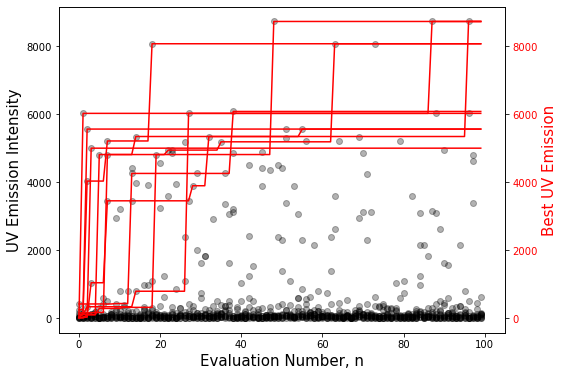

iterations to the max UV: 100.0+/-0.0


In [15]:
import matplotlib.pyplot as plt
from botorch.acquisition import UpperConfidenceBound

    
plt.figure(0)
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

max_x = 0
max_y = 0
steps = []
UVs=[]
#for i in [9]:
for i in range(len(log_seed)):
    max_xi, max_yi = add_one_ensemble(log_seed,i)
    steps.append(max_xi)
    UVs.append(max_yi)
    max_x = max(max_xi,max_x)
    max_y = max(max_yi,max_y)

FontSize = 15
ax1.set_ylim(-max_y*0.05,max_y*1.05)
ax2.set_ylim(-max_y*0.05,max_y*1.05)
ax1.set_xlabel('Evaluation Number, n', fontsize = FontSize)
ax1.set_ylabel('UV Emission Intensity', fontsize = FontSize)
ax2.set_ylabel('Best UV Emission', color='r', fontsize = FontSize)
plt.setp(ax2.get_yticklabels(), color="red")
# plt.axvspan(x[0]-x[-1]*0.05, 9.5, color='#00A1FF', alpha=0.19)
# plt.axvspan(9.5, x[-1]+x[-1]*0.05, color='#F8CF6A', alpha=0.19)
plt.xlim([-max_x*0.05,max_x*1.05])
    
plt.show()
print(f'iterations to the max UV: {np.mean(steps)}+/-{np.std(steps)}')

In [5]:
# data for max_uv vs iteration plot
def get_max_stat(log_seed):
    max_uv_all = []
    for i in range(len(log_seed)):
        df = pd.DataFrame((log_seed[i]))
        df.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']
        evalued = len(df)
        max_uv = []
        y = df.UV
        for i in range(evalued):
            max_uv.append(df.iloc[0:i+1].UV.max())

        max_uv_all.append(max_uv)
    y = np.mean(max_uv_all,axis=0)
    std = np.std(max_uv_all,axis=0)
    stderr = std/np.sqrt(len(max_uv_all))
    x = range(len(max_uv))
    return x,y,stderr

# data for count of top uv vs iteration plot
def get_top_stat(log_seed):
    top_count_all = []
    for i in range(len(log_seed)):
        df = pd.DataFrame((log_seed[i]))
        df.columns =['yb_1', 'er_1', 'yb_2', 'er_2','radius','UV']
        evalued = len(df)
        top_count = []
        y = df.UV
        for i in range(evalued):
            df_i = df.iloc[0:i+1]
            top_count.append(len(df_i[df_i['UV']>=3000]))
        top_count_all.append(top_count)

    y = np.mean(top_count_all,axis=0)
    std = np.std(top_count_all,axis=0)
    stderr = std/np.sqrt(len(top_count_all))
    x = range(len(top_count))
    return x, y, stderr

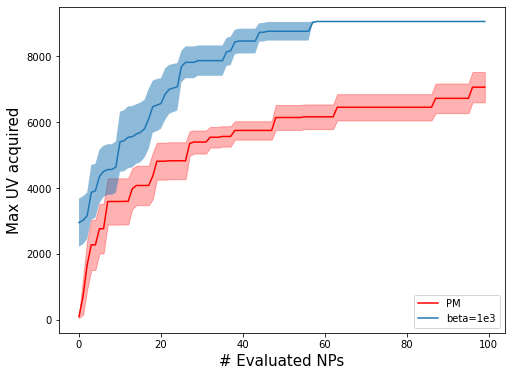

In [16]:
df0 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_RS.pkl", "rb" ) )
df1 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1000.pkl", "rb" ) )
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_max_stat(df0)
plt.plot(x,y,c='r',label='PM')
plt.fill_between(x, y-stderr, y+stderr, color='r',alpha=0.3)
x,y,stderr = get_max_stat(df1)
plt.plot(x,y,label='beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, alpha=0.5)
plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('Max UV Acquired', fontsize = FontSize)
plt.legend(loc='lower right')


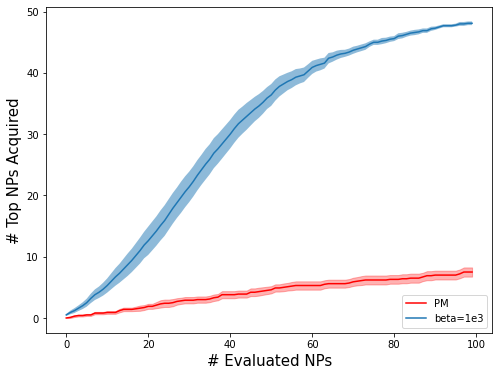

In [17]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_top_stat(df0)
plt.plot(x,y,c='r',label='PM')
plt.fill_between(x, y-stderr, y+stderr, color='r',alpha=0.3)
x,y,stderr = get_top_stat(df1)
plt.plot(x,y,label='beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, alpha=0.5)
plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('# Top NPs Acquired', fontsize = FontSize)
plt.legend(loc='lower right')

In [32]:
df = pd.read_csv("../saved_data/simulation_log_from_gsheet.csv")
df.nlargest(51, 'UV')


,yb_1,er_1,yb_2,er_2,radius,UV,VIS,BLUE,GREEN,RED,TOTAL,ABSORPTION,qe
621,0.725410,0.004203,0.000000,0.000000,22.201403,9049.999376,6137.499535,1024.999923,1037.499925,1462.499873,16362.498870,116987.491600,0.022292
675,0.725277,0.004274,0.000000,0.000000,22.210646,8731.249449,5881.249608,1018.749935,1106.249928,1306.249909,15612.499010,117906.242500,0.021257
674,0.726799,0.003840,0.000000,0.000000,22.194860,8074.999453,4924.999658,812.499945,924.999930,899.999939,13624.999050,131462.490800,0.020013
664,0.668532,0.019422,0.034536,0.001199,25.481699,6081.249433,7562.499280,1356.249874,1862.499803,3037.499724,14031.248679,75912.492678,0.009437
620,0.622377,0.026710,0.000000,0.000000,21.551992,6024.999091,8149.998670,1362.499762,1599.999748,3412.499438,14612.497690,45137.492860,0.019065
669,0.671682,0.018834,0.034780,0.001073,25.399717,5562.498950,6612.498790,1318.749787,1706.249678,2312.499581,12568.747701,78649.985916,0.008580
665,0.664623,0.020641,0.036690,0.001297,25.472231,5362.499418,7487.499235,1212.499880,1949.999798,3056.249684,13199.998604,72399.992518,0.008780
666,0.710296,0.022646,0.036726,0.001391,25.508667,5343.749663,7681.249528,1318.749918,2043.749875,3062.499822,13443.749175,75487.495441,0.008373
670,0.672597,0.018177,0.034242,0.001014,25.380177,5287.499352,6793.749178,1418.749815,1937.499760,2481.249718,12868.748444,76774.990899,0.008782
352,0.545866,0.016335,0.000000,0.000000,20.996052,5212.498170,5249.998106,956.249678,1249.999572,1818.749319,10949.996160,42262.485080,0.020804


array([[<AxesSubplot:title={'center':'UV'}>]], dtype=object)

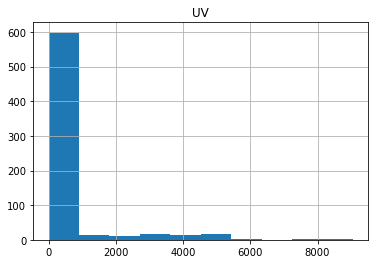

In [29]:
df.hist(column = "UV",bins=10)

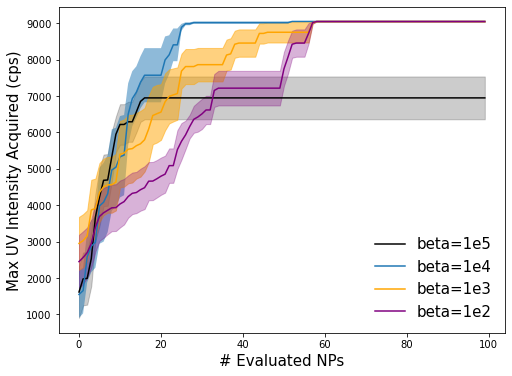

In [36]:
import pickle
df0 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1e5.pkl", "rb" ) )
df1 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1e4.pkl", "rb" ) )
df2 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1000.pkl", "rb" ) )
df3 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=100.pkl", "rb" ) )
df4 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1.pkl", "rb" ) )
df5 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p1.pkl", "rb" ) )
df6 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p001.pkl", "rb" ) )



FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_max_stat(df0)
plt.plot(x,y,c='black',label='beta=1e5')
plt.fill_between(x, y-stderr, y+stderr, color='black',alpha=0.2)
x,y,stderr = get_max_stat(df1)
plt.plot(x,y,label='beta=1e4')
plt.fill_between(x, y-stderr, y+stderr, alpha=0.5)
x,y,stderr = get_max_stat(df2)
plt.plot(x,y,c='orange', label='beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, color='orange',alpha=0.5)
x,y,stderr = get_max_stat(df3)
plt.plot(x,y,c='purple', label='beta=1e2')
plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.3)
# x,y,stderr = get_max_stat(df4)
# plt.plot(x,y,c='purple', label='beta=1')
# plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.2)
# # beta = 0.1
# x,y,stderr = get_max_stat(df5)
# plt.plot(x,y,c='green', label='beta=0.1')
# plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.2)
# # beta = 0.001
# x,y,stderr = get_max_stat(df6)
# plt.plot(x,y,c='brown', label='beta=0.001')
# plt.fill_between(x, y-stderr, y+stderr, color='brown',alpha=0.2)

plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('Max UV Intensity Acquired (cps)', fontsize = FontSize)
plt.legend(loc='lower right', fontsize = FontSize,frameon=False)

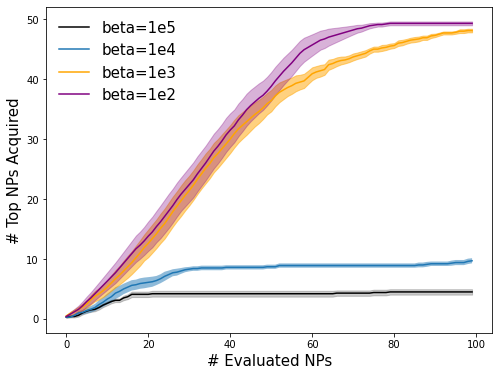

In [37]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8, 6))

x,y,stderr = get_top_stat(df0)
plt.plot(x,y,c='black',label='beta=1e5')
plt.fill_between(x, y-stderr, y+stderr, color='black',alpha=0.2)
x,y,stderr = get_top_stat(df1)
plt.plot(x,y,label='beta=1e4')
plt.fill_between(x, y-stderr, y+stderr, alpha=0.5)
x,y,stderr = get_top_stat(df2)
plt.plot(x,y,c='orange', label='beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, color='orange',alpha=0.5)
# beta = 100
x,y,stderr = get_top_stat(df3)
plt.plot(x,y,c='purple', label='beta=1e2')
plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.3)
# beta = 1
# x,y,stderr = get_top_stat(df4)
# plt.plot(x,y,c='purple', label='beta=1')
# plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.2)
# beta = 0.1
# x,y,stderr = get_top_stat(df5)
# plt.plot(x,y,c='green', label='beta=0.1')
# plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.2)
# # beta = 0.001
# x,y,stderr = get_top_stat(df6)
# plt.plot(x,y,c='brown', label='beta=0.001')
# plt.fill_between(x, y-stderr, y+stderr, color='brown',alpha=0.2)


plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('# Top NPs Acquired', fontsize = FontSize)
plt.legend(loc='upper left', fontsize = FontSize, frameon=False)

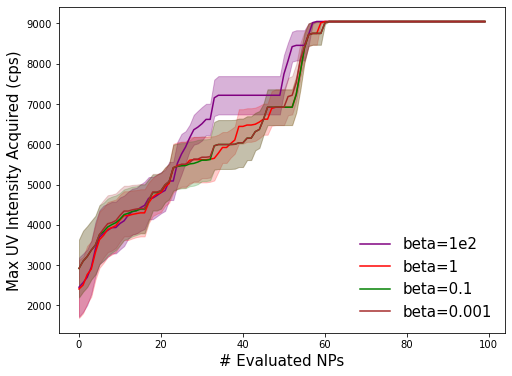

In [50]:
import pickle
df0 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1e5.pkl", "rb" ) )
df1 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1e4.pkl", "rb" ) )
df2 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1000.pkl", "rb" ) )
df3 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=100.pkl", "rb" ) )
df4 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1.pkl", "rb" ) )
df5 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p1.pkl", "rb" ) )
df6 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p001.pkl", "rb" ) )



FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

# x,y,stderr = get_max_stat(df0)
# plt.plot(x,y,c='black',label='beta=1e5')
# plt.fill_between(x, y-stderr, y+stderr, color='black',alpha=0.2)
# x,y,stderr = get_max_stat(df1)
# plt.plot(x,y,label='beta=1e4')
# plt.fill_between(x, y-stderr, y+stderr, alpha=0.5)
# x,y,stderr = get_max_stat(df2)
# plt.plot(x,y,c='orange', label='beta=1e3')
# plt.fill_between(x, y-stderr, y+stderr, color='orange',alpha=0.5)
x,y,stderr = get_max_stat(df3)
plt.plot(x,y,c='purple', label='beta=1e2')
plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.3)
x,y,stderr = get_max_stat(df4)
plt.plot(x,y,c='r', label='beta=1')
plt.fill_between(x, y-stderr, y+stderr, color='r',alpha=0.2)
# beta = 0.1
x,y,stderr = get_max_stat(df5)
plt.plot(x,y,c='green', label='beta=0.1')
plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.2)
# beta = 0.001
x,y,stderr = get_max_stat(df6)
plt.plot(x,y,c='brown', label='beta=0.001')
plt.fill_between(x, y-stderr, y+stderr, color='brown',alpha=0.2)

plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('Max UV Intensity Acquired (cps)', fontsize = FontSize)
plt.legend(loc='lower right', fontsize = FontSize,frameon=False)

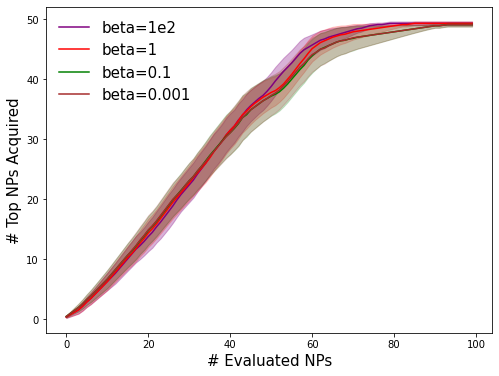

In [52]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_top_stat(df3)
plt.plot(x,y,c='purple', label='beta=1e2')
plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.3)
x,y,stderr = get_top_stat(df4)
plt.plot(x,y,c='r', label='beta=1')
plt.fill_between(x, y-stderr, y+stderr, color='r',alpha=0.2)
# beta = 0.1
x,y,stderr = get_top_stat(df5)
plt.plot(x,y,c='green', label='beta=0.1')
plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.2)
# beta = 0.001
x,y,stderr = get_top_stat(df6)
plt.plot(x,y,c='brown', label='beta=0.001')
plt.fill_between(x, y-stderr, y+stderr, color='brown',alpha=0.2)

plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('# Top NPs Acquired', fontsize = FontSize)
plt.legend(loc='upper left', fontsize = FontSize, frameon=False)


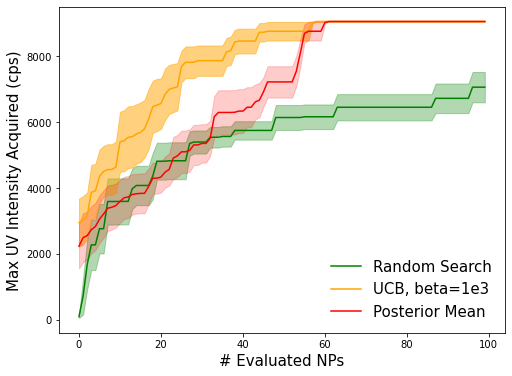

In [53]:
import pickle
df0 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_RS.pkl", "rb" ) )
df1 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1000.pkl", "rb" ) )
df2 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_PosteriorMean.pkl", "rb" ) )
df3 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_PI.pkl", "rb" ) )
df4 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1.pkl", "rb" ) )
df5 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p1.pkl", "rb" ) )
df6 = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=0p001.pkl", "rb" ) )



FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_max_stat(df0)
plt.plot(x,y,c='green',label='Random Search')
plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.3)
x,y,stderr = get_max_stat(df1)
plt.plot(x,y,c='orange',label='UCB, beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, color='orange',alpha=0.5)
x,y,stderr = get_max_stat(df2)
plt.plot(x,y,c='red', label='Posterior Mean')
plt.fill_between(x, y-stderr, y+stderr, color='red',alpha=0.2)
x,y,stderr = get_max_stat(df3)
# plt.plot(x,y,c='purple', label='Probability of Improvement')
# plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.3)
# x,y,stderr = get_max_stat(df4)
# plt.plot(x,y,c='purple', label='beta=1')
# plt.fill_between(x, y-stderr, y+stderr, color='purple',alpha=0.2)
# # beta = 0.1
# x,y,stderr = get_max_stat(df5)
# plt.plot(x,y,c='green', label='beta=0.1')
# plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.2)
# # beta = 0.001
# x,y,stderr = get_max_stat(df6)
# plt.plot(x,y,c='brown', label='beta=0.001')
# plt.fill_between(x, y-stderr, y+stderr, color='brown',alpha=0.2)

plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('Max UV Intensity Acquired (cps)', fontsize = FontSize)
plt.legend(loc='lower right', fontsize = FontSize,frameon=False)

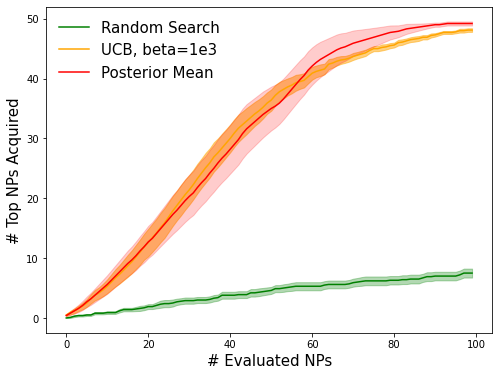

In [54]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8,6))

x,y,stderr = get_top_stat(df0)
plt.plot(x,y,c='green',label='Random Search')
plt.fill_between(x, y-stderr, y+stderr, color='green',alpha=0.3)
x,y,stderr = get_top_stat(df1)
plt.plot(x,y,c='orange',label='UCB, beta=1e3')
plt.fill_between(x, y-stderr, y+stderr, color='orange',alpha=0.5)
x,y,stderr = get_top_stat(df2)
plt.plot(x,y,c='red', label='Posterior Mean')
plt.fill_between(x, y-stderr, y+stderr, color='red',alpha=0.2)
x,y,stderr = get_max_stat(df3)


plt.xlabel('# Evaluated NPs', fontsize = FontSize)
plt.ylabel('# Top NPs Acquired', fontsize = FontSize)
plt.legend(loc='upper left', fontsize = FontSize, frameon=False)

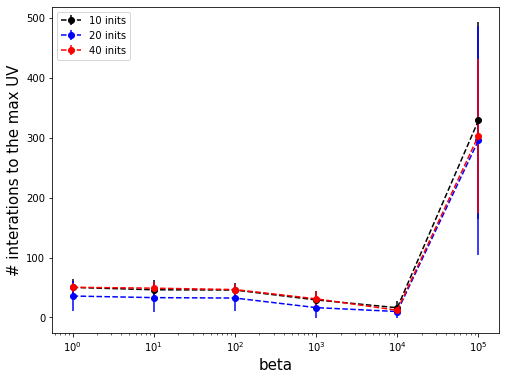

In [86]:
FontSize = 15
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.xlabel('beta', fontsize = FontSize)
plt.ylabel('# interations to the max UV', fontsize = FontSize)

plt.errorbar(beta_list, mean_10inits, std_10inits, label = '10 inits', c='black', marker='o',linestyle='dashed')
plt.errorbar(beta_list, mean_20inits, std_20inits, label = '20 inits', c='b',marker='o',linestyle='dashed')
plt.errorbar(beta_list, mean_40inits, std_40inits, label = '40 inits', c='red',marker='o',linestyle='dashed')
plt.xscale('log')    

plt.legend(loc='upper left')
plt.show()